<a href="https://colab.research.google.com/github/msilver22/data_augmentation/blob/main/fashionMNIST/fashionMNIST_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-lightning --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 1.0 MB/s eta 0:00:00


In [2]:
!pip install lightning --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 18.6 MB/s eta 0:00:00


In [3]:
import os
import lightning as L
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import matplotlib.pyplot as plt
import scipy
import torch.optim as optim

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
BATCH_SIZE = 64
NUM_WORKERS = int(os.cpu_count() / 2)
print(f'Number of workers: {NUM_WORKERS}')
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")

Using device: cuda
Number of workers: 1


In [5]:
class FashionMNISTDataModule(L.LightningDataModule):
    def __init__(
        self,
        data_dir: str = PATH_DATASETS,
        batch_size: int = BATCH_SIZE,
        num_workers: int = NUM_WORKERS,
    ):
        super().__init__()

        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
            ])
        self.dims = (1, 28, 28)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            fmnist_full = datasets.FashionMNIST(self.data_dir, train=True, download = True, transform=self.transform)
            self.fmnist_train, self.fmnist_val = random_split(fmnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.fmnist_test = datasets.FashionMNIST(self.data_dir, train=False, download = True, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(
            self.fmnist_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(self.fmnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.fmnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [6]:
class Generator(nn.Module):
    def __init__(self, in_features=100, out_features=784):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256,512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, out_features),
            nn.Tanh()
        )

    def forward(self, z):
        z = self.model(z)
        z = z.view(z.size(0), -1)
        return z

In [7]:
class Discriminator(nn.Module):
    def __init__(self, in_features=784, out_features=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256,out_features)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [11]:
class GAN(L.LightningModule):
    def __init__(
        self,
        latent_dim: int = 100,
        lr: float = 0.0002,
        k : int=5,
        b1: float = 0.5,
        b2: float = 0.999,
        batch_size: int = BATCH_SIZE,
        **kwargs,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False

        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        self.k = k

        # networks
        self.generator = Generator(in_features=self.latent_dim, out_features=784)
        self.discriminator = Discriminator(in_features=784,out_features=1)

        # loss
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.training_step_outputs_d = []
        self.training_step_outputs_g = []
        self.d_losses = []
        self.g_losses = []

    def forward(self, z):
        return self.generator(z)

    def real_loss(self, predicted_outputs, loss_fn, device):

        # Targets are set to 1 here because we expect prediction to be
        # 1 (or near 1) since samples are drawn from real dataset
        batch_size = predicted_outputs.size(0)
        targets = torch.ones(batch_size).to(device)
        real_loss = loss_fn(predicted_outputs.squeeze(), targets)

        return real_loss

    def fake_loss(self, predicted_outputs, loss_fn, device):

        # Targets are set to 0 here because we expect prediction to be
        # 0 (or near 0) since samples are generated fake samples
        batch_size = predicted_outputs.size(0)
        targets = torch.zeros(batch_size).to(device)
        fake_loss = loss_fn(predicted_outputs.squeeze(), targets)

        return fake_loss

    def training_step(self, batch):
        imgs, _ = batch
        imgs = imgs.to(device)

        optimizer_g, optimizer_d = self.optimizers()

        ## ----------------------------------------------------------------
        ## Train discriminator using real and then fake MNIST images,
        ## then compute the total-loss and back-propogate the total-loss
        ## ----------------------------------------------------------------

        self.toggle_optimizer(optimizer_d)

        for _ in range(self.k):
          # Real MNIST images
          d_real_logits_out = self.discriminator(imgs)
          d_real_loss = self.real_loss(d_real_logits_out, self.loss_fn, device)
          # Fake images
          with torch.no_grad():
            # Generate a batch of random latent vectors
            z = np.random.uniform(-1, 1, size=(self.batch_size, self.latent_dim))
            z = torch.from_numpy(z).float().to(device)
            # Generate batch of fake images
            fake_images = self(z)
          # feed fake-images to discriminator and compute the
          # fake_loss (i.e. target label = 0)
          d_fake_logits_out = self.discriminator(fake_images)
          d_fake_loss = self.fake_loss(d_fake_logits_out, self.loss_fn, device)

          # Compute total discriminator loss
          d_loss = d_real_loss + d_fake_loss
          self.log('d_loss', d_loss, on_step=True, prog_bar=True, logger=True)
          self.manual_backward(d_loss)
          optimizer_d.step()
          optimizer_d.zero_grad()

        self.untoggle_optimizer(optimizer_d)

        ## ----------------------------------------------------------------
        ## Train generator, compute the generator loss which is a measure
        ## of how successful the generator is in tricking the discriminator
        ## and finally back-propogate generator loss
        ## ----------------------------------------------------------------

        self.toggle_optimizer(optimizer_g)

        # Generate a batch of random latent vectors
        z = np.random.uniform(-1, 1, size=(self.batch_size, self.hparams.latent_dim))
        z = torch.from_numpy(z).float().to(device)
        # Generate a batch of fake images, feed them to discriminator
        # and compute the generator loss as real_loss
        # (i.e. target label = 1)
        fake_images = self.generator(z)
        g_logits_out = self.discriminator(fake_images)
        g_loss = self.real_loss(g_logits_out, self.loss_fn, device)
        self.log("g_loss", g_loss, prog_bar=True)
        self.manual_backward(g_loss)
        optimizer_g.step()
        optimizer_g.zero_grad()
        self.untoggle_optimizer(optimizer_g)

        self.training_step_outputs_d.append(d_loss)
        self.training_step_outputs_g.append(g_loss)

    def on_train_epoch_end(self):
        d_loss_epoch = torch.stack(self.training_step_outputs_d).mean()
        g_loss_epoch = torch.stack(self.training_step_outputs_g).mean()
        self.d_losses.append(d_loss_epoch.item())
        self.g_losses.append(g_loss_epoch.item())
        self.training_step_outputs_d.clear()  # free memory
        self.training_step_outputs_g.clear()

        # Save generator weights at specific epochs
        save_epochs = [1, 5, 10, 20, 40, 60, 80, 100, 200]
        if self.current_epoch + 1 in save_epochs:
           torch.save(self.generator.state_dict(), f'generator_epoch_{self.current_epoch + 1}.pth')

    def configure_optimizers(self):
        lr = self.lr
        b1 = self.b1
        b2 = self.b2
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | generator     | Generator         | 1.5 M  | train
1 | discriminator | Discriminator     | 1.5 M  | train
2 | loss_fn       | BCEWithLogitsLoss | 0      | train
------------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.786    Total estimated model params size (MB)
26        M

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


[LOG] Generator weights saved.


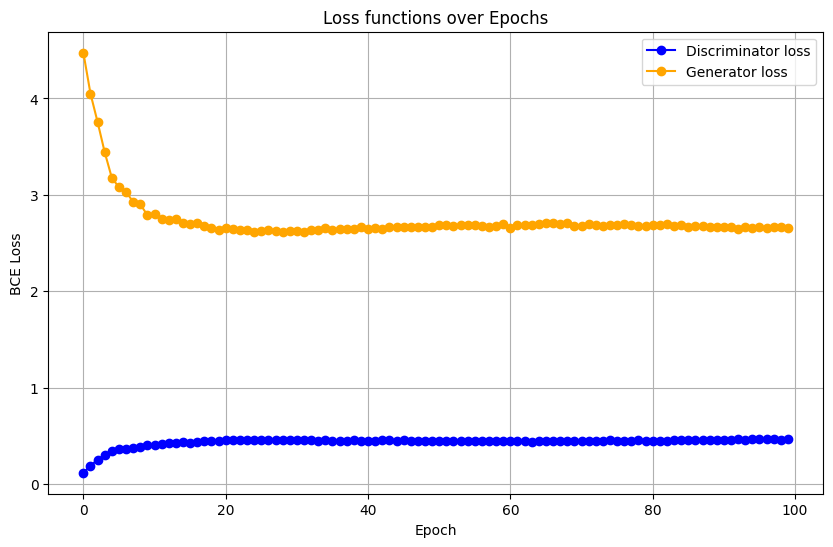

In [12]:
def main():
    dm = FashionMNISTDataModule()
    model = GAN()
    trainer = L.Trainer(
        max_epochs=100,
    )
    trainer.fit(model, dm)
    torch.save(model.generator.state_dict(), 'generator_weights_final.pth')
    print("[LOG] Generator weights saved.")
    d_losses = model.d_losses
    g_losses = model.g_losses
    plot_epochs = range(0, len(g_losses))

    plt.figure(figsize=(10, 6))
    plt.plot(plot_epochs, d_losses, "-o", label="Discriminator loss", color="blue")
    plt.plot(plot_epochs, g_losses, "-o", label="Generator loss", color="orange")
    plt.title("Loss functions over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("BCE Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()

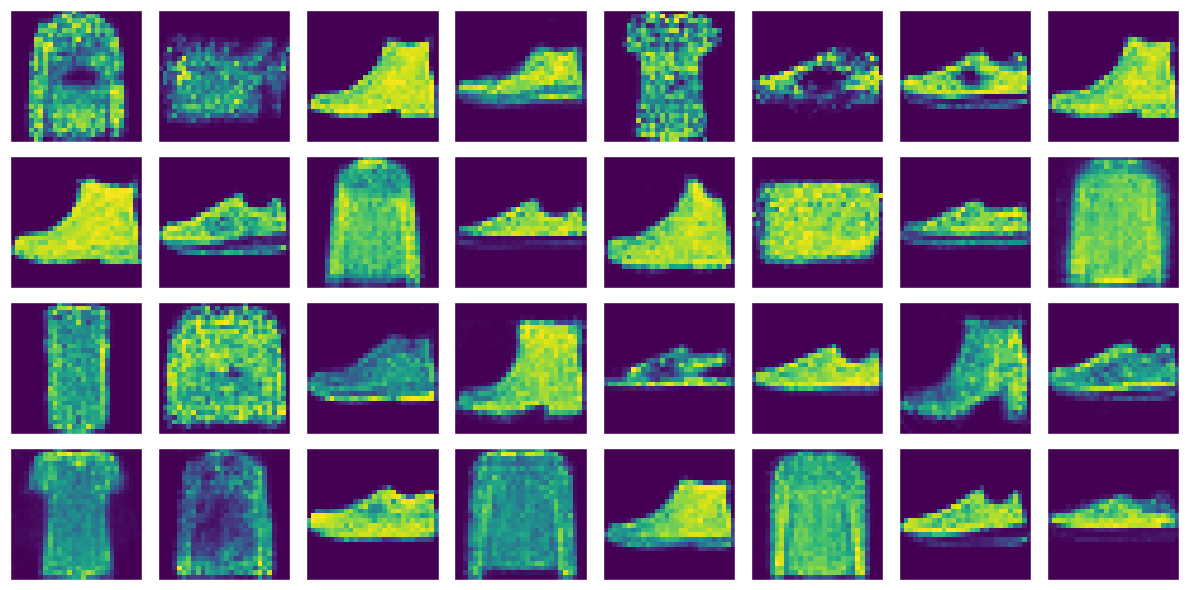

In [21]:
import math

def display_images(images, n_cols=4, figsize=(12, 6)):

    plt.style.use('ggplot')
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)
    plt.figure(figsize=figsize)
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        image = images[idx]
        # make dims H x W x C
        image = image.permute(1, 2, 0)
        cmap = plt.cm.viridis
        ax.imshow(image, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

latent_dim = 100
g = Generator(in_features=100, out_features=784)
g.load_state_dict(torch.load('generator_epoch_100.pth'))
g.eval()
z = np.random.uniform(-1, 1, size=(32, 100))
z = torch.from_numpy(z).float()
fake_images = g(z)
# Reshape and display
fake_images = fake_images.view(32, 1, 28, 28).detach()
display_images(fake_images, n_cols=8)